In [1]:
from PIL import Image
import donkey as dk
import numpy as np


Using TensorFlow backend.


In [2]:
sh = dk.sessions.SessionHandler('/home/wroscoe/donkey_data/sessions/')

In [3]:
sessions = ['diff_lines', 'diff_lines2', 'diff_lines3', 'diff_lines4', 'diff_lines5'] 


In [4]:
from random import shuffle

img_paths = []
for s in sessions:
    session = sh.load(s)
    img_paths = img_paths + session.img_paths()
    
img_paths_shuffled=img_paths[:]
shuffle(img_paths_shuffled)
    

Loading Session
Loading Session
Loading Session
Loading Session
Loading Session


In [5]:
import math
import random
def trisplit_list(lst, val=.1, test=.1):
    count = len(lst)
    train_val_cutoff = math.ceil(count*(1-val-test))
    val_test_cutoff = math.ceil(count*(1-test))
    
    train = lst[:train_val_cutoff]
    val = lst[train_val_cutoff:val_test_cutoff]
    test = lst[val_test_cutoff:]
    
    return train, val, test

In [6]:

def frame_generator(img_paths):
    while True:
        for f in img_paths:
            img_arr, data = load_frame(f)
            data_arr = np.array(data['angle'])
            yield img_arr, data_arr
            

In [7]:
def load_frame(file_path):
    ''' 
    Retrieve an image and the data saved with it.
    '''

    with Image.open(file_path) as img:
        img_arr = np.array(img)

    data = dk.sessions.parse_img_filepath(file_path)
    return img_arr, data

In [8]:
def batch_generator(img_paths, batch_size=32):
    frames = frame_generator(img_paths)
    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            x, y = next(frames)
            X.append(x)
            Y.append(y)
        X = np.array(X)
        Y = np.array(Y)
        yield X, Y
    

In [9]:
def load_dataset(img_paths):
    '''
    Returns image arrays and data arrays.

        X - array of n samples of immage arrays representing.  
        Y - array with the shape (samples, 1) containing the 
            angle lable for each image

        Where n is the number of recorded images.
    '''

    gen = frame_generator(img_paths)

    X = [] #images
    Y = [] #velocity (angle, speed)
    for _ in range(len(img_paths)):
        x, y = next(gen)
        X.append(x)
        Y.append(y)

    X = np.array(X) #image array [[image1],[image2]...]
    Y = np.array(Y) #array [[angle1, speed1],[angle2, speed2] ...]

    return X, Y

In [10]:
train, val, test = trisplit_list(img_paths_shuffled, val=.05, test=.05)
train_gen = batch_generator(train, batch_size=32)
val_data = load_dataset(val)
test_data = load_dataset(test)

In [11]:
X, Y = next(train_gen)
X.shape

(32, 120, 160, 3)

In [15]:
import keras
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, SimpleRNN, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

def cnn3_full1():

    img_in = Input(shape=(120, 160, 3), name='img_in')
    angle_in = Input(shape=(1,), name='angle_in')
    
    x = Convolution2D(8, 3, 3)(img_in)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Convolution2D(16, 3, 3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Convolution2D(32, 3, 3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    merged = Flatten()(x)
    
    x = Dense(256)(merged)
    x = Activation('relu')(x)
    x = Dropout(.2)(x)
    angle_out = Dense(1, name='angle_out')(x)

    model = Model(input=[img_in], output=[angle_out])
    model.compile(optimizer=adam, loss='mean_squared_error')

    return model

In [26]:
model = dk.models.cnn3_full1_rnn1()


In [27]:
len(train)

18947

In [28]:
model.fit_generator(train_gen, samples_per_epoch = 18947, nb_epoch = 5, 
                    validation_data=val_data)


Epoch 1/5
18944/18947 [============================>.] - ETA: 0s - loss: 542.1493     

/home/wroscoe/code/donkey/env/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


18976/18947 [==============================] - 609s - loss: 541.2350 - val_loss: 0.0237
Epoch 2/5
18976/18947 [==============================] - 676s - loss: 0.0248 - val_loss: 0.0189

In [29]:
X, Y = test_data
Y_predicted = model.predict(X)

In [30]:

Y_predicted = Y_predicted.reshape((Y_predicted.shape[0]))

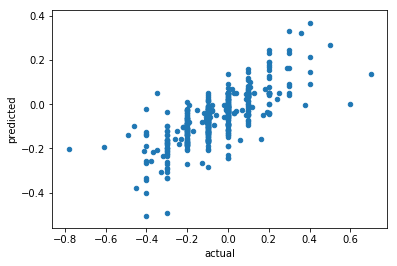

In [31]:
import pandas as pd
%matplotlib inline
df = pd.DataFrame({'actual': Y[600:], 'predicted': Y_predicted[600:]})
df.plot.scatter(x='actual', y='predicted')

In [32]:
model.save('diff_drive_linear_model')

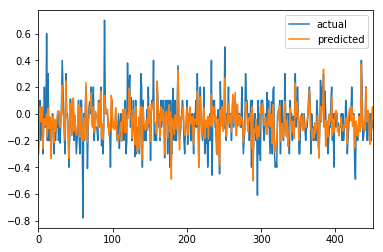

In [33]:
df.plot()